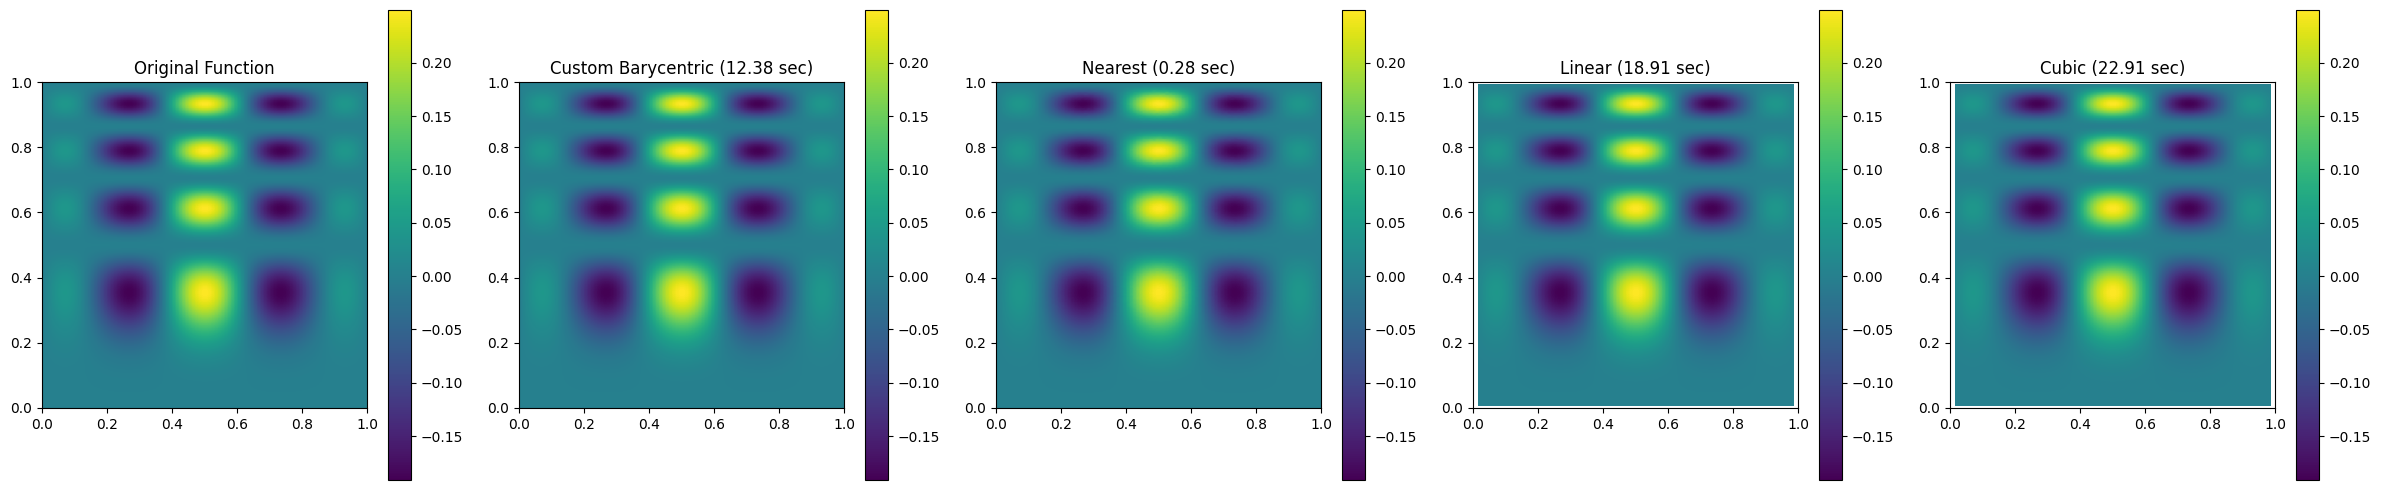

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from scipy.interpolate import griddata
import time
from matplotlib.colors import LogNorm



def cart_to_barycentric(x, y, triangulation_object, triangle_index):
    p = np.vstack((x, y)).T
    valid_indices = triangle_index != -1
    bary = np.zeros((len(x), 3))  # Initialize to zero; will remain zero if not valid
    
    if valid_indices.any():
        # Process valid points only
        for i in np.where(valid_indices)[0]:
            trans = triangulation_object.transform[triangle_index[i]]
            b0 = np.dot(trans[:2, :2], p[i] - trans[2])
            b0 = np.round(b0, 5)
            b1 = 1 - b0.sum()
            bary[i] = np.array([b0[0], b0[1], b1])
    return bary

def barycentric_interpolate(xp, yp, tri, xyz):
    p = np.vstack((xp, yp)).T
    tri_indices = tri.find_simplex(p)
    bary = cart_to_barycentric(xp, yp, tri, tri_indices)
    interpolated_values = np.zeros(len(xp))
    
    valid = tri_indices != -1
    for i in np.where(valid)[0]:
        simplex = tri.simplices[tri_indices[i]]
        interpolated_values[i] = np.dot(bary[i], xyz[simplex, 2])

    return interpolated_values

# Sample 


def func(x, y):
    return x * (1 - x) * np.cos(4 * np.pi * x) * np.sin(4 * np.pi * y**2)**2


# Sample data generation
points = np.random.rand(1000000, 2)
values = func(points[:, 0], points[:, 1])

# Delaunay triangulation
tri = Delaunay(points)
xyz = np.c_[points, values]

# Grid for interpolation
grid_x, grid_y = np.mgrid[0:1:100j, 0:1:200j]
exact_values = func(grid_x, grid_y)
#################################################################################################################################
# Time and perform custom barycentric interpolation
start_custom = time.time()
interpolated_barycentric = barycentric_interpolate(grid_x.ravel(), grid_y.ravel(), tri, xyz)
time_custom = time.time() - start_custom
grid_z3 = interpolated_barycentric.reshape(grid_x.shape)
#################################################################################################################################
#Scipy methods
methods = ['nearest', 'linear', 'cubic']
interpolations = []
times = [time_custom]
for method in methods:
    start_time = time.time()
    interpolated = griddata(points, values, (grid_x, grid_y), method=method)
    interpolations.append(interpolated)
    times.append(time.time() - start_time)

# Plotting results for interpolations including the original function
titles = ['Original Function', 'Custom Barycentric', 'Nearest', 'Linear', 'Cubic']
results = [exact_values] + [grid_z3] + interpolations
fig, axes = plt.subplots(1, len(results), figsize=(24, 5))
for i, ax in enumerate(axes):
    im = ax.imshow(results[i].T, extent=(0, 1, 0, 1), origin='lower')
    ax.set_title(f"{titles[i]}{'' if i == 0 else ' ({:.2f} sec)'.format(times[i-1])}")
    fig.colorbar(im, ax=ax, orientation='vertical')
plt.tight_layout()
plt.show()


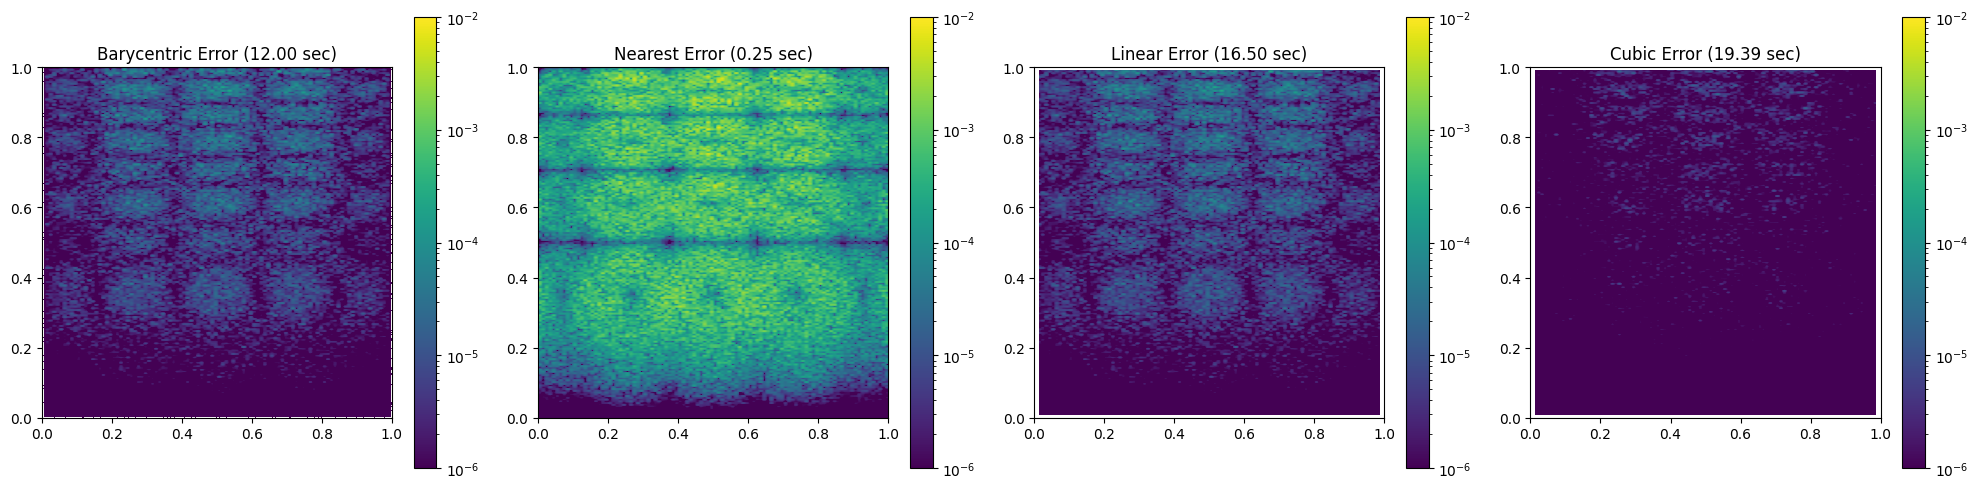

In [4]:

errors = [np.abs(exact_values - interpolated).reshape(grid_x.shape) for interpolated in [grid_z3] + interpolations]
error_titles = ['Barycentric Error', 'Nearest Error', 'Linear Error', 'Cubic Error']

fig, axes = plt.subplots(1, len(errors), figsize=(20, 5))
for i, ax in enumerate(axes):
    im_error = ax.imshow(errors[i].T, extent=(0, 1, 0, 1), norm=LogNorm(vmin=0.000001, vmax=0.01), origin='lower', cmap='viridis')
    ax.set_title(f"{error_titles[i]} ({times[i]:.2f} sec)")
    fig.colorbar(im_error, ax=ax, orientation='vertical')
plt.tight_layout()
plt.show()

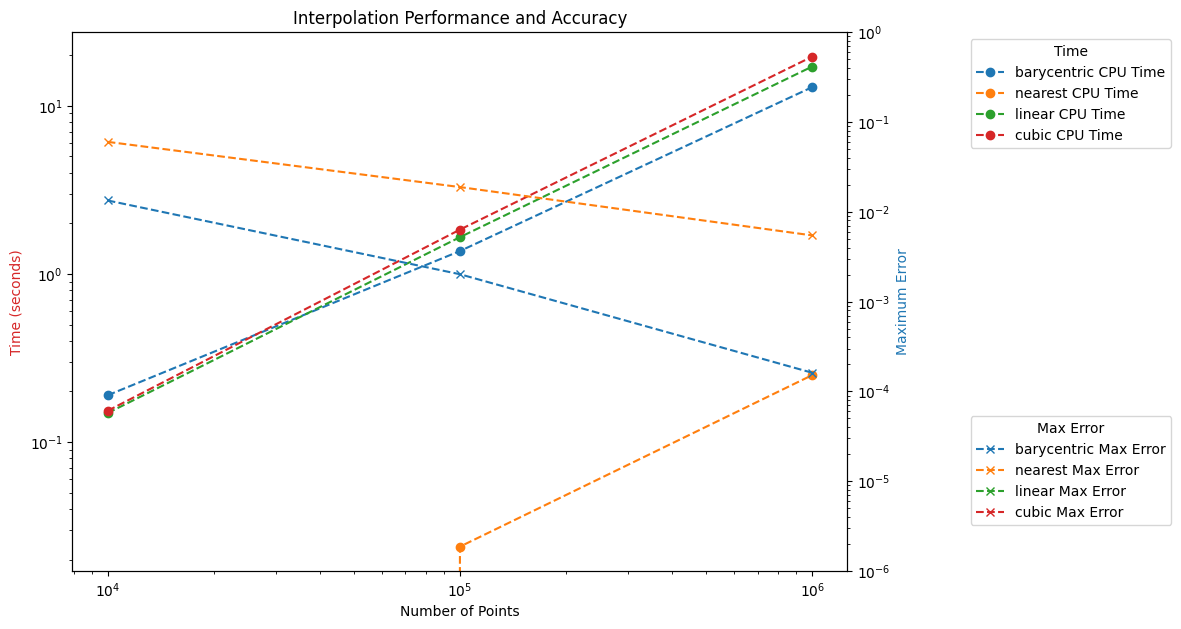

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from scipy.interpolate import griddata
import time

def perform_interpolations(points_count):
    points = np.random.rand(points_count, 2)
    values = func(points[:, 0], points[:, 1])
    tri = Delaunay(points)
    xyz = np.c_[points, values]

    grid_x, grid_y = np.mgrid[0:1:100j, 0:1:100j]
    exact_values = func(grid_x, grid_y)

    methods = ['barycentric', 'nearest', 'linear', 'cubic']
    times = []
    max_errors = []
    results = {}

    # Barycentric interpolation
    start_time = time.time()
    interpolated_barycentric = barycentric_interpolate(grid_x.ravel(), grid_y.ravel(), tri, xyz)
    time_barycentric = time.time() - start_time
    results['barycentric'] = interpolated_barycentric.reshape(grid_x.shape)
    error_barycentric = np.abs(exact_values - results['barycentric']).max()
    times.append(time_barycentric)
    max_errors.append(error_barycentric)

    # SciPy interpolation methods
    for method in ['nearest', 'linear', 'cubic']:
        start_time = time.time()
        interpolated = griddata(points, values, (grid_x, grid_y), method=method)
        elapsed_time = time.time() - start_time
        results[method] = interpolated
        error = np.abs(exact_values - interpolated).max()
        times.append(elapsed_time)
        max_errors.append(error)

    return times, max_errors, results

# Test point counts
point_counts = [10**4, 10**5, 10**6]
methods = ['barycentric', 'nearest', 'linear', 'cubic']
times_by_method = {method: [] for method in methods}
errors_by_method = {method: [] for method in methods}
interpolation_results = {method: [] for method in methods}

for count in point_counts:
    times, errors, results = perform_interpolations(count)
    for method_index, method in enumerate(methods):
        times_by_method[method].append(times[method_index])
        errors_by_method[method].append(errors[method_index])
        interpolation_results[method].append(results[method])

# Plotting results
fig, ax1 = plt.subplots(figsize=(10, 7))
ax2 = ax1.twinx()
ax1.set_xlabel('Number of Points')
ax1.set_ylabel('Time (seconds)', color='tab:red')
ax2.set_ylabel('Maximum Error', color='tab:blue')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.set_yscale('log')
ax2.set_ylim(1e-6, 1)  # Adjust the y-axis range

for method in methods:
    ax1.plot(point_counts, times_by_method[method], marker='o', label=f"{method} CPU Time", linestyle='-')
    ax2.plot(point_counts, errors_by_method[method], marker='x', label=f"{method} Max Error", linestyle='--')

ax1.legend(loc='upper left', bbox_to_anchor=(1.15, 1), title='Time')
ax2.legend(loc='upper left', bbox_to_anchor=(1.15, 0.3), title='Max Error')
plt.title('Interpolation Performance and Accuracy')
plt.show()
